# Milestone 4: Analysis and Visualisation 

In [24]:
# Preamble - imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sbn 
# from scipy.stats import ks_2samp

ModuleNotFoundError: No module named 'scipy'

In [2]:
# finance_df = pd.read_csv("df_after_Task_6.csv") # All should be cleaned now, dates parsed, etc. 
# type(finance_df) # confirming it's a pd.df :)  
# I've commented out the df above since it got rid of all my useful columns- I will use the data 'cleaned' up to but not including the removal of highly correlated columns instead. 
finance_df = pd.read_csv("df_end_of_Task_5.csv")

**Aside:** Upon trying to find suitable columns to 'summarise currently what percentage of the loans are recovered against hte investor funding and the total amount funded,' I realised that data cleaning task number 6 removed all the potentially appropriate columns for that task, namely: 
- **out_prncp**: Remaining outstanding principal for total amount funded
- **out_prncp_inv**: Remaining outstanding principal for portion of total amount funded by investors
- **total_payment**: Payments received to date for total amount funded

I am shocked by the pedagogical blundering that would lead to such an oversight- students don't know where they're going or what sort of analysis will be asked of them, so they don't know how to properly clean the data without utterly destroying its utility, and the casually wirtten data 'cleaning' prompts encourage a cavalier attitude about maintaining data. 

This is why I'm importing the csv from the end of task 5 instead of task 6. 

In [ ]:
# print(finance_df.dtypes) # plopped into loan_data_dict.md for further reference. 

## Task 1: Current state of loans 
1. Summarise currently what percentage of the loans are recovered against the investor funding and the total amount funded. 
2. Visualise the results of the above. 
3. Visualise what percentage of the total amount would be recovered up to 6 months in the future. 

For the first prompt, I'll use the following columns: 
- **out_prncp_inv**: Remaining outstanding principal for portion of total amount funded by investors

In [ ]:
out_prncp_inv = finance_df["out_prncp_inv"]

#out_prncp_inv.head(20)


In [11]:
print(finance_df.shape, out_prncp_inv.size)

(54210, 41) 54210


In [4]:
out_prncp_inv.nlargest(10)

3219    32399.94
1859    31973.38
666     31063.10
2845    31038.00
1763    30981.57
1415    30981.55
1577    30933.50
3783    30933.50
1908    30872.20
21      30782.74
Name: out_prncp_inv, dtype: float64

In [5]:
out_prncp_inv.nsmallest(10)

2     0.0
3     0.0
6     0.0
7     0.0
25    0.0
38    0.0
40    0.0
42    0.0
43    0.0
46    0.0
Name: out_prncp_inv, dtype: float64

In [6]:

out_prncp_inv.mean()

2752.9240243497507

In [7]:
out_prncp_inv.median()

0.0

What the stats above tell us is that 50% of loans are fully paid off (The median outstanding is 0.), and out_prncp_inv is measured most likely in pounds or dollars, not as a percentage. (Just checking for quick wins. ;)

In [8]:
(out_prncp_inv==0).sum()

33946

From the above I can see there are 33946 zeros (i.e. no outstanding debt, i.e. fully repaid loans) out of 54210, so 62.62% of loans are fully repaid. Task 1's first prompt asks us to summarise what percentage of loans are recovered against the investor funding and total amount funded. The 'against' portions of that question are bit confusing, but I can say 62% of loans have been recovered; I'll check that statement using the recoveries column, and visualise, as requested in prompt two. 

To recap from loan_data_dict.md: 
**recoveries**: post charge off gross recovery

If they actually are asking what percentage of **money loaned* is recovered, that is a different story... 

In [12]:
recoveries = finance_df["recoveries"]
print(recoveries.size, recoveries.nlargest(10), recoveries.nsmallest(10))

54210 29116    16188.880000
36980    15236.310000
37278    14165.110000
37297    14004.010000
49268    14000.160000
29414    13900.000000
8428     13832.920000
49140    13777.020000
44938    13425.987971
37594    12961.320000
Name: recoveries, dtype: float64 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: recoveries, dtype: float64 89.52323483605744 0.0


In [13]:
recoveries.mean()

89.52323483605744

In [14]:
recoveries.median()

0.0

In [15]:
# Noticed mean and median different, suggests skew... 

recoveries.skew() # 11 - yep, highly skewed. 

11.206563566763865

In [16]:
#So how many recoveries are at 0? 
(recoveries==0).sum()

50558

As you can see from the above, a whopping 50558/54210 = 93.26% of recoveries are at 0; this is neither equal to, nor the complement of, the 62% of loans have no principal left to pay (out_prncp_inv, if I understand that correctly). I don't think it's entirely clear from the data description what the real difference is between these two measures, but whatever. I've now provided two percentages that could describe how many of the loans "are recovered." 

Of interest is the "against the investor" portion of the prompt--- my question is, do you want me to identify the percentage of recoveries **per member_id**?? That's the closest to a variable that indicates a human being involved in the transaction; however, that is, according to the loan_data_dict, an identifier of the borrower, not the investor (who would be lending). So that interpretation may be a stretch. 

- **id**: unique id of the loan
- **member_id**: id of the member to took out the loan

Furthermore, this seems like a needlessly arguous (because it's unlike to lead to meaningful insights) task unless there are 20 or fewer investors. So I'll check that before I do anything crazy: 

In [17]:
member_id = finance_df["member_id"]
member_id.nunique()

54210

54210. Since there are as many unique member_id's as there are loans, it would be pointless to report on percentages with respect to the member_id - they'd all be 0% or 100% individually. 

The other part of that prompt was to look at percentage of recovered loans "against total amount funded." 
Perhaps a simple way to consider this would be to look at a binary status of recovery, much as we've been interpreting the 0's in 'recoveries' and 'out_prncp_inv.' I'll identify the mean total loan_amount for each status, 'recovered,' (0), and 'unrecovered' (>0), and see if there's an interesting relationship (or just coincidental difference in means) using box plots and hypothesis testing. 

**loan_amount**: amount of loan the applicant received

In [18]:
#Since the description of "recoveries" makes no sense to me, I'm going to consider the out_prncp_inv measure for understanding how many loans are recovered: 
finance_df_copy = finance_df.copy()

cleared_loans = finance_df_copy[finance_df_copy['out_prncp_inv'] == 0]
ongoing_loans = finance_df_copy[finance_df_copy['out_prncp_inv'] > 0]

In [19]:
cleared_loans["loan_amount"].mean()

12368.03452542273

In [20]:
ongoing_loans["loan_amount"].mean()

14940.470785629688

From the above we can see the average loan amount is higher in the group of still-unpaid loans. (Makes sense. Can't pay it off faster just because you want to, and there's more distance to run.)

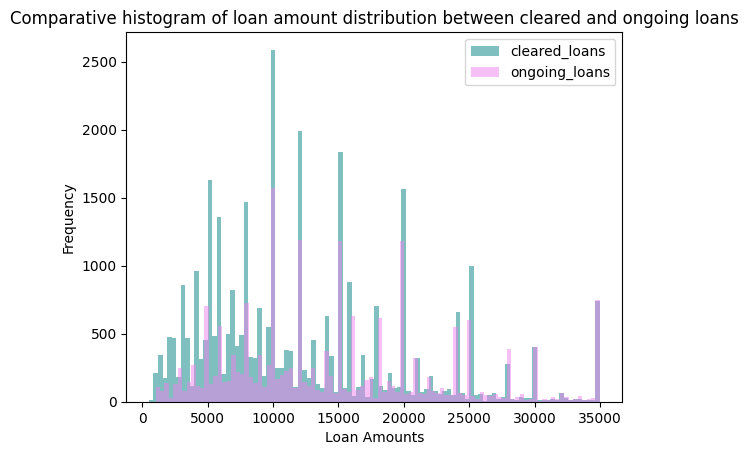

In [22]:
# The hypothesis test most suited depends on the distribution of the two datasets being compared. 
plt.hist(cleared_loans['loan_amount'], bins=100,alpha=0.5,label='cleared_loans', color='teal') 
plt.hist(ongoing_loans['loan_amount'], bins=100,alpha=0.5,label='ongoing_loans', color = 'violet')
plt.xlabel("Loan Amounts")
plt.ylabel("Frequency")
plt.title("Comparative histogram of loan amount distribution between cleared and ongoing loans")
plt.legend()
plt.show()

In [ ]:
#Now do a hypothesis test with Kolmogorov-Smirnov test: 
"""
statistic, p_value = ks_2samp(ongoing_loans["loan_amount"], cleared_loans["loan_amount"])

alpha = 0.05 # Sig lvl 
if p_value < alpha: 
    print(f"Since {p_value} is less than 0.05, we have enough evidence to reject the null hypothesis: the loan amounts of the cleared loans are markedly different from the loan amounts of the ongoing loans.")
else: 
    print(f"Since {p_value} is greater than 0.05, there isn't enough evidence to reject the null. loan amounts from both samples may come from the same population.")
    """

1. Summarise currently what percentage of the loans are recovered against the investor funding and the total amount funded. 
2. Visualise the results of the above. 
3. Visualise what percentage of the total amount would be recovered up to 6 months in the future. 